# QOSF Mentorship Task 2
## Task: Given 4 initial random states, construct a quantum circuit that transforms those initial states into predefined output states.
For simplicity, we choose non super-position states, i.e. bit-strings $ \left|1001\right\rangle, \left|1010\right\rangle$, etc. however the method below may be generalised to an arbitrary superposition(quantum) state. More detailed discussion on this later

In [1]:
%matplotlib agg
#Import qiskit foundation and other required packages
import qiskit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import combinations
from pprint import pprint
from IPython.display import display

In [2]:
#Import required objects for building Variational Quantum Circuit
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

#Import objects for optimization routines
from qiskit.algorithms.optimizers import SLSQP

In [3]:
#Print Qiskit Version
for key, value in qiskit.qiskit.__qiskit_version__.items():
    if value == None:
        value = "None"
    print("{key:<25} : {value:<10}".format(key=key, value=value))

qiskit-terra              : 0.17.4    
qiskit-aer                : 0.8.2     
qiskit-ignis              : 0.6.0     
qiskit-ibmq-provider      : 0.13.1    
qiskit-aqua               : 0.9.1     
qiskit                    : 0.26.2    
qiskit-nature             : None      
qiskit-finance            : None      
qiskit-optimization       : 0.1.0     
qiskit-machine-learning   : None      


In [4]:
#Using statevector for smaller qubit systems (here 4 qubits)
simulator_instance = QuantumInstance(Aer.get_backend("statevector_simulator"))

#Optimizer
optimizer = SLSQP()

## Idea for Variational Circuit: 

Variational circuit is inspired by Grover and QAOA type variational circuit. 
Instead of phase inversion(in Grover), use a QAOA-type Z and ZZ rotations for changing relative phases of states,
And instead of inversion about mean(in Grover), also use QAOA-like X-rotations, but make it more general by applying a layer of Hadamards to change to X-basis
then we are free to apply the same Z and ZZ rotation as before. We repeat this, just like in QAOA, where each layer of Hadamards is a basis change between X and Z.

In [5]:
#Using 4 qubits
phase_gates = QuantumCircuit(4, name = "U_p")

#To keep track of variational parameters
variational_parameters = []
param_counter = 0 #number of parameters

#Add Z rotation for each qubit
for i in range(4):
    param = Parameter('t_{}'.format(param_counter))
    variational_parameters.append(param)
    param_counter += 1
    phase_gates.rz(param, i)

# Add ZZ rotation by ( CX * I.Rz * CX ) just like in QAOA
# where I.Rz is one Z rotation on either of the two qubits, (I for applying identity on the other qubit).
for i, j in combinations(range(4), 2):
    param = Parameter('t_{}'.format(param_counter))
    variational_parameters.append(param)
    param_counter += 1
    phase_gates.cx(i, j)
    phase_gates.rz(param, j)
    phase_gates.cx(i, j)       

## This is what the " phase gate, $U_p$ " looks like, where we treat $U_p$ as a gate of 4 qubits

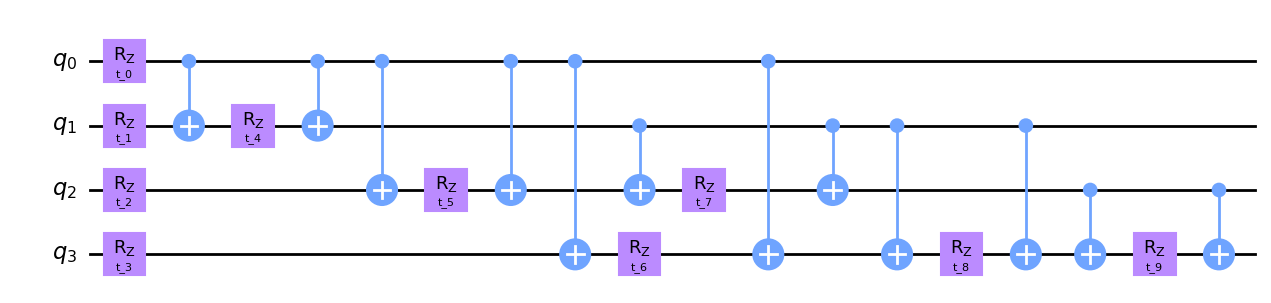

In [6]:
fig = phase_gates.draw('mpl') 
display(fig)

In [7]:
#number of variational parameters in one phase gate
param_counter

10

## Construction method:
The idea is to first apply a layer of Hadamards HHHH, so that when providing an initial state, e.g. 1010 by applying XIXI from the 0000 state, $XIXI\left|0000\right\rangle = \left|1010\right\rangle$, the resulting gates would be XIXI followed by HHHH. Then, since HX = ZH, overall this simply becomes HHHH followed by ZIZI, that is $H_1 H_2 H_3 H_4 X_1 X_3 = Z_1 Z_3 H_1 H_2 H_3 H_4 $, and this is one of the ways of "marking" some state in an equal superposition by changing the phase of that state, just as in Grover's Algorithm. Therefore, our initial state (when appended to the left) will "mark" some state after applying a layer of Hadamards. This is diagramatically shown below. Here, LHS circuit is what we will have in our variational circuit, but the RHS is a type of "marking of states" from an equal superposition.
![alt text](phase_gates.png)

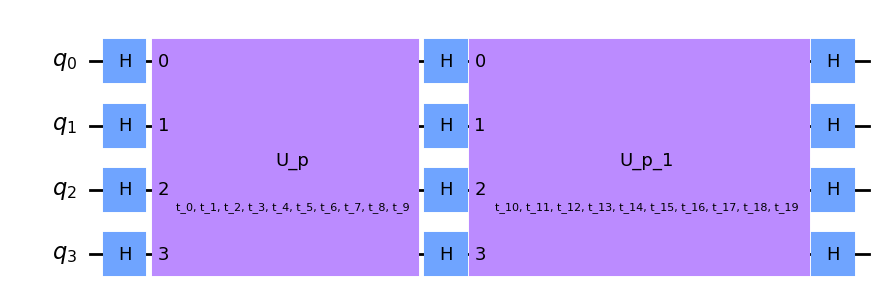

In [8]:
#We first build what a single layer of the variational circuit would be for demonstration.

#Initialize variational circuit
#Note, the initial state will be appended to the left of the circuit, just as shown in diagram above with X1 X3 = XIXI
variational_circ = QuantumCircuit(4)
phase_counter = 0 #Counter for number of phase_gates applied

variational_circ.h(range(4))
variational_circ.append(phase_gates, range(4))
phase_counter += 1

#Switch to X basis
variational_circ.h(range(4))

#Assign new parameters in phase_gate/U_p
new_params = {} #New dict for re-assignment of parameters
for k in range(param_counter):
    r = k + phase_counter*param_counter
    new_params[variational_parameters[k]] = Parameter('t_{}'.format(r))
new_phase_gates = phase_gates.assign_parameters(new_params, inplace = False) #Assign new paramger
new_phase_gates.name = 'U_p_{}'.format(phase_counter)
variational_circ.append(new_phase_gates, range(4))

# Switch back to Z basis before measuring
variational_circ.h(range(4))

#Draw (with U_p not decomposed)
fig = variational_circ.draw('mpl')
display(fig)

# Similarity with QAOA

Here we annotate the similarity with QAOA with two Hamiltonians one consisting of Z and ZZ terms, the other of X and XX terms.
This is a heuristic as to why we may want to apply the phase gates repeatedly with a layer of Hadamards in between each $U_p$, just as QAOA alternates with Z, ZZ rotations and X rotations to bring the ground state of one (simple) Hamiltonian to the other. We don't have that "simple" Hamiltonian here in our scenario (although there may be a nice way to encode our problem into such a Hamiltonian), however IF there were such a Hamiltonian, we can think of the desired solution as the ground state of such a Hamiltonian.
![alt text](one_layer.png)

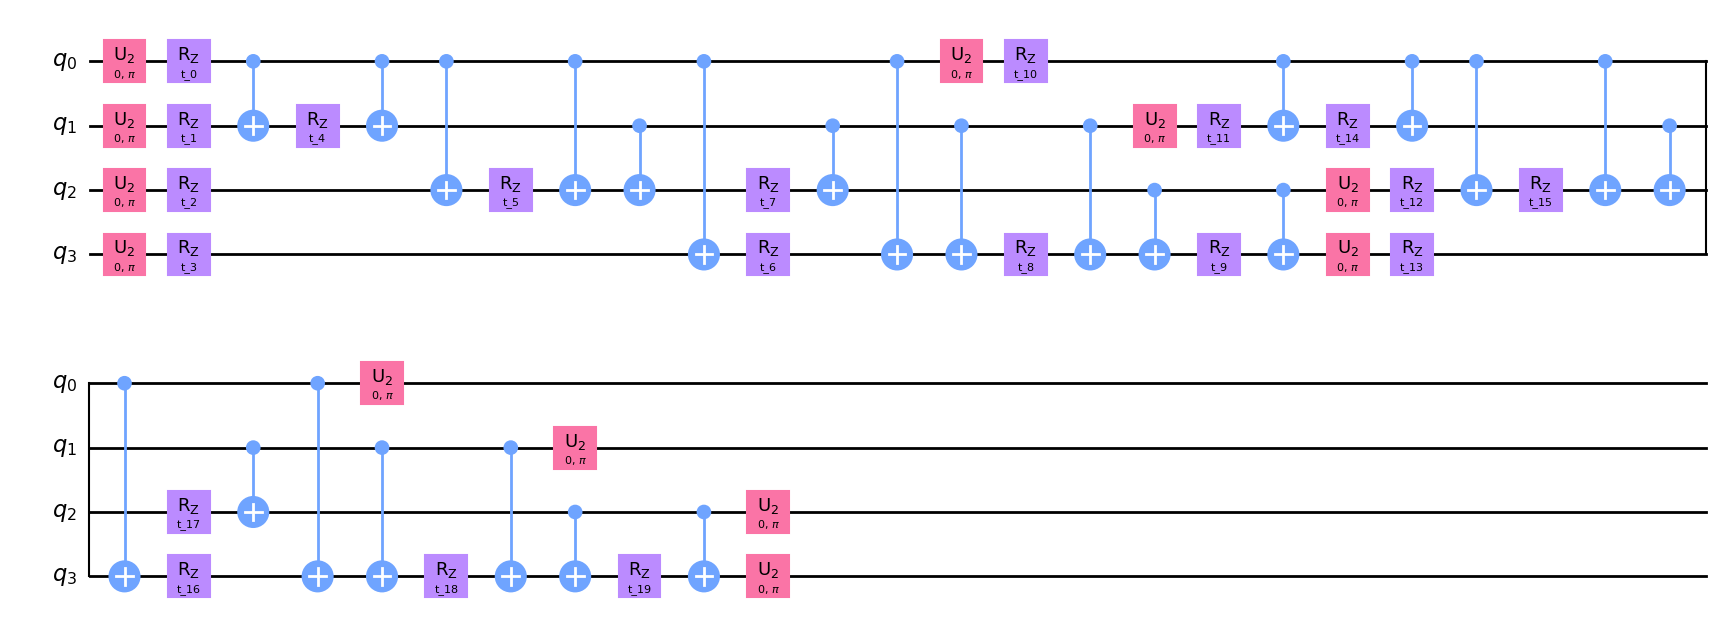

In [9]:
#This is simply the circuit above with each U_p decomposed into one and two-qubit gates.
fig = variational_circ.decompose().draw('mpl')
display(fig)

In [10]:
#For the task, apply the circuit n number of times:
n=2 #2 layers

variational_circ = QuantumCircuit(4)
phase_counter = 0 #Counter for number of phase_gates applied

variational_circ.h(range(4))
all_params = []
phase_counter = 0
#n layers of the above circuit, i.e. 2*n phase gates with Hadamards in between each
for i in range(2*n): 
    #Assigning of new parameters
    new_params = {}
    for k in range(param_counter):
        r = k + phase_counter*param_counter
        new_param = Parameter('t_{}'.format(r))
        new_params[variational_parameters[k]] = new_param
        all_params.append(new_param)
    new_phase_gates = phase_gates.assign_parameters(new_params, inplace = False) #Assign new paramger
    new_phase_gates.name = 'U_p_{}'.format(phase_counter)
    variational_circ.append(new_phase_gates, range(4))
    variational_circ.h(range(4))
    phase_counter += 1

## Restatement of task: Given 4 initial random states, provide a quantum circuit that transforms those initial states into predefined output states.

In the following, states are randomly chosen to be "1001", "0011", "0100" and "1110". Again, we note that these four states do not contain any superposition.
We construct these states as follows.

In [11]:
input_states = ["1001", "0011", "0100", "1110"]
states = []
for state_str in input_states:
    state = QuantumCircuit(4)
    for i in range(4):
        #Note: reversed string in qiskit convention where top register is least significant bit
        if state_str[i] == "1": 
            state.x(4-i-1)
    states.append(state)

In [12]:
#E.g. Draw first state (state 0):
print(states[0].draw())

     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘


In [13]:
#Now the output states:
output_states = ["0011", "0101", "1010", "1100"]

#Dict of input-output pair:
input_output = dict(zip(input_states, output_states))

In [14]:
#We make a cost function that maximises the probability of the predefined output states
#Since optimizer is for minimization, we simple negate the cost function to minimize instead.
def cost_fn(params):
    """Cost function for the (-1)*probabilities of predefined output states, with a contribution from each input-output state pairs. Multiplied by -1 for minimization.

    Args:
        params ([Dict or List or np.array]): Dict or list or array of parameter assignment. If List or np.array, it will be assigned in the order of the existing parameters of the circuit

    Returns:
        cost: float for the negative of the probabilities
    """
    #global variables
    global variational_circ 
    global states
    global simulator_instance

    negative_probabilities = []
    
    #For each input_output pair, get its probability contribution to the cost function
    for i, (input_str, output_str) in enumerate(input_output.items()):
        #Combine input state circuit to the left and assign parameters
        circ = states[i].compose( variational_circ.assign_parameters(params, inplace=False) ) 
        
        #Simulate and get probability
        result = simulator_instance.execute(circ)
        statevec = Statevector(result.get_statevector())
        result_probs = statevec.probabilities_dict()
        nve_probability = -1.0 * result_probs.get(output_str, 0)
        #Append result
        negative_probabilities.append(nve_probability)
    
    #Total cost=sum(negative_probabilities)
    return sum(negative_probabilities)

In [15]:
#Training of circuit according to the minimization of cost fn.

#Start at some random point    
params = [ np.random.rand() for _ in range(param_counter * 2 * n) ]

#1000 SLSQP iterations
optimizer.set_options(maxiter = 1000)

#Optimize
point, value, nfev = optimizer.optimize(param_counter*2*n, cost_fn, initial_point = params)

In [16]:
#Print results. We know the optimal value should be -4, since the maximum contribution from each of the four states is when the desired output is 100% probability, so prob = 1.0. 
#I.e. optimal_cost = -4 * 1.0 = -4.0, so we know the circuit is fully trained when the optimal value is returned as -4.0.
print(point, value, nfev)

[ 1.44931899e+00  1.57091204e+00  1.46964432e+00 -3.46810013e-05
  1.57066953e+00 -5.95278845e-01  1.97669421e-04  7.67829127e-05
  8.09056019e-06  1.57076538e+00  1.57096076e+00  6.60338452e-05
  1.57081081e+00  8.78838594e-01  1.46644759e+00  1.23866957e-01
 -1.55821211e-05  6.31606327e-01  6.32943308e-01 -2.31753880e-04
  1.09751020e+00  9.87822244e-01  8.09008438e-01  2.81924425e-04
  1.57818732e-01  4.97212218e-04 -2.08826000e-04  6.02660536e-01
  2.95390170e-04  3.65115306e-05  1.44087229e-05  1.15588541e-04
  1.84141389e-04 -9.08512288e-05 -3.12511415e-04 -1.52955120e-04
 -1.09672634e-04  1.57058482e+00 -3.26122585e-05  1.46998700e+00] -3.999999082645807 1073


So we see that the optimal value is very close to -3.9999 (very close to -4.0), which means the training did as expected, and it took 1073 evaluations of the cost function.

Initial_state: 1001
Output_state: 0011


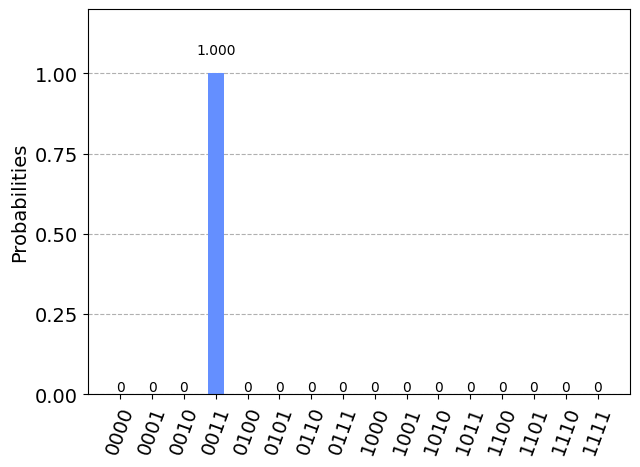

Initial_state: 0011
Output_state: 0101


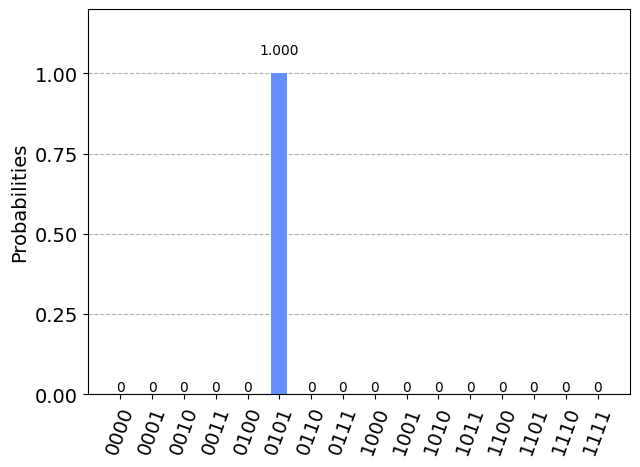

Initial_state: 0100
Output_state: 1010


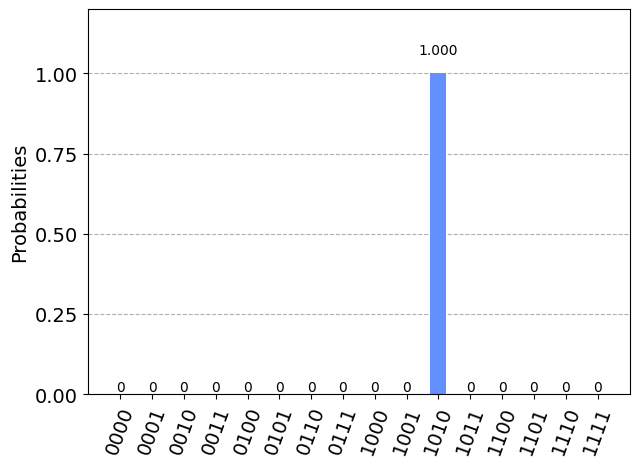

Initial_state: 1110
Output_state: 1100


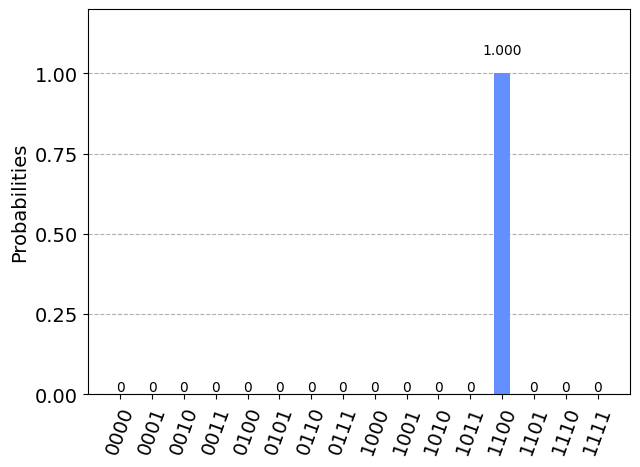

In [17]:
#CHECKING OF RESULT
#First build circuit with trained parameters:
optimal_circuit = variational_circ.assign_parameters(point, inplace = False)

#Now we check the probabilities of final state if the initial state is combined to the left of the circuit.
for i in range(4):
    print( "Initial_state: {}".format(input_states[i]) )
    print( "Output_state: {}".format(input_output[input_states[i]]) )
    circ = states[i].compose(optimal_circuit)
    result = simulator_instance.execute(circ)
    statevec = Statevector(result.get_statevector())
    result_probs = statevec.probabilities_dict()
    fig = display(plot_histogram(result_probs))  

# Training went well.
As can be seen from the plots above, the output_state does indeed have a 100% probability of measurement.

However, if we were to use different initial input states, it is suspected that the output state will no longer be one of the four pre-defined output states. We can think of the trained circuit produced here as a circuit that maps precisely one of the four input states to one of the four output states. What the circuit does to other input states had nothing to do with the training and hence it is hard to say what the output will be.

Some interesting cases to look at would be if we instead used a superposition of the input states. For example, $\dfrac{1}{\sqrt{2}}\left(\ \left|1001\right\rangle + \left|0011\right\rangle\ \right)$. We may use Qiskit's initialize method to create such a superposition.

In [19]:
#Statevector of initial superposition
initial_sv = np.zeros( shape = (2**4) )
initial_sv[3] = 1/np.sqrt(2) #0011 = 3 
initial_sv[9] = 1/np.sqrt(2) #1001 = 9

#Initialize Quantum Circuit
initial_state = QuantumCircuit(4)
initial_state.initialize( initial_sv )

#Check if correct initial_state superposition. Should have (0011: 0.5) and (1001: 0.5)
Statevector(initial_state).probabilities_dict()

{'0000': 5.0759401314267256e-33,
 '0001': 4.299812834130694e-67,
 '0010': 1.8672185282817305e-33,
 '0011': 0.4999999999999999,
 '1000': 4.454409789741128e-33,
 '1001': 0.4999999999999998,
 '1010': 8.270936893512594e-34,
 '1011': 9.247544657061553e-66}

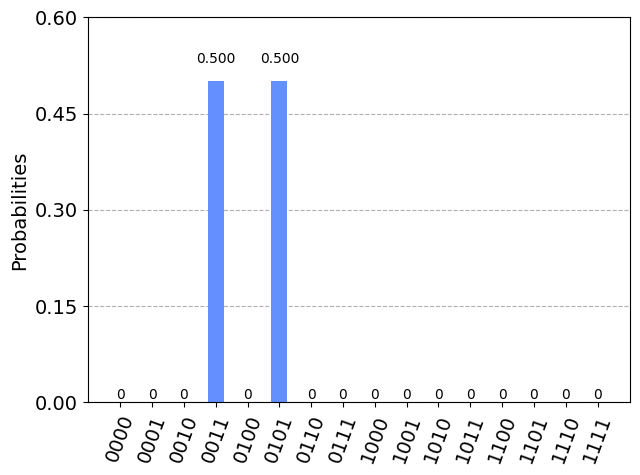

In [20]:
#Now see histogram if using this initial state instead.
circ = initial_state.compose(optimal_circuit)
statevec = Statevector(circ)
result_probs = statevec.probabilities_dict()
fig = plot_histogram(result_probs)
display(fig)

So using an initial superposition of the four initial states also seems to return a superposition of the output states.

What happens then if we use some other binary string state not in one of the four initial states? e.g. 0000 (we don't need to append an initial state for this)

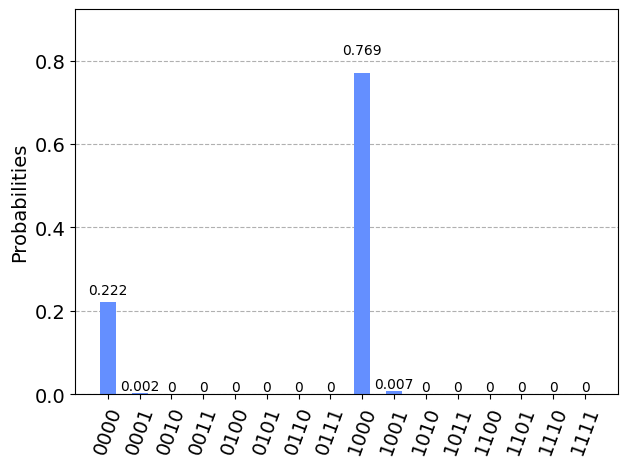

In [21]:
statevec = Statevector(optimal_circuit)
result_probs = statevec.probabilities_dict()
fig = plot_histogram(result_probs)
display(fig)

Here, it makes sense that the output no longer is in one of the four predefined output states. So, if we wanted to use NEW initial states, we would need to retrain the variational circuit. Let's try that.

And to make things more interesting, let's use some superpositions as our initial state, so we use Statevectors to initialize our initial_state as above.

In [22]:
input_states = [[5,6], [5,5,6], [1,2,3], [1,3,4,7]]  #Superposition of binary bit strings in integer representation
states = []
for state_rep in input_states:
    state = QuantumCircuit(4)
    sv = np.zeros( shape = (2**4, ) )
    for integer_rep in state_rep:
        sv[integer_rep] = 1
    sv /= np.linalg.norm(sv)
    state.initialize(sv)
    states.append(state)

In [23]:
#Retrain circuit by optimizing again
params = [ np.random.rand() for _ in range(param_counter * 2 * n) ]
point, value, nfev = optimizer.optimize(param_counter*2*n, cost_fn, initial_point = params)

Input_state(superposn of): [5, 6]
Output_state: 0011


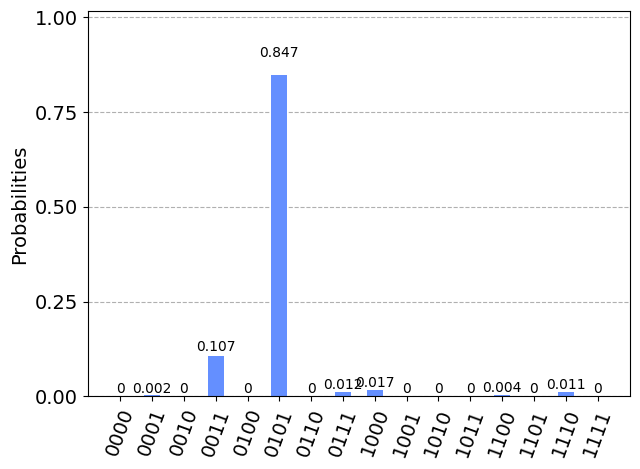

Input_state(superposn of): [5, 5, 6]
Output_state: 0101


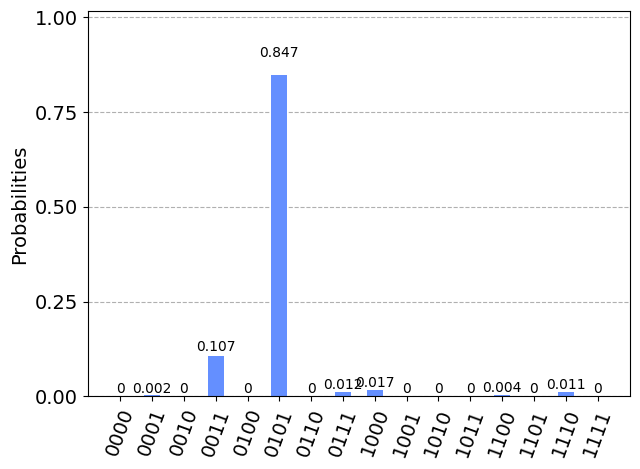

Input_state(superposn of): [1, 2, 3]
Output_state: 1010


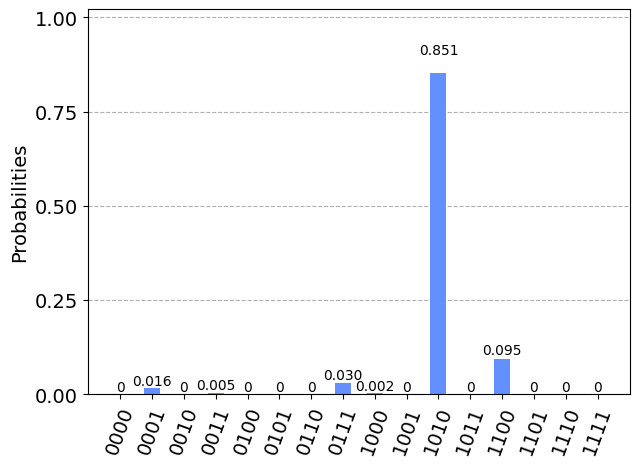

Input_state(superposn of): [1, 3, 4, 7]
Output_state: 1100


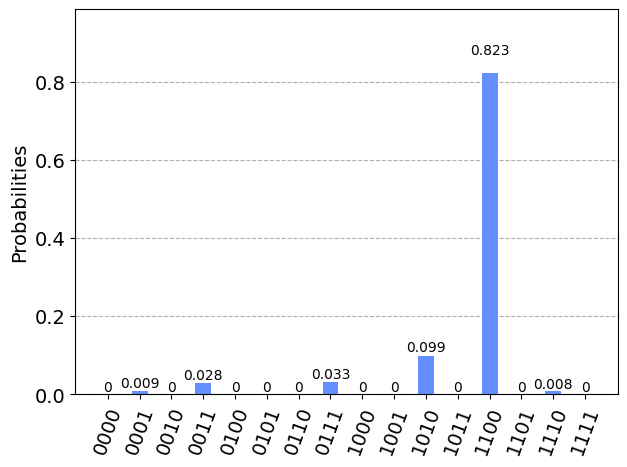

In [26]:
#Again plot histograms for each of the four new initial (superposition) states
optimal_circuit = variational_circ.assign_parameters(point, inplace = False)
for i in range(4):
    print( "Input_state(superposn of): {}".format(input_states[i]) )
    print( "Output_state: {}".format(list(input_output.values())[i]) )
    circ = states[i].compose(optimal_circuit)
    result = simulator_instance.execute(circ)
    statevec = Statevector(result.get_statevector())
    result_probs = statevec.probabilities_dict()
    fig = display(plot_histogram(result_probs))  

In [27]:
print(point, value, nfev)

[-2.50355654e-01  3.21082092e-01  1.57066881e+00 -1.10303195e+00
  3.41240883e+00  3.41656000e-04  1.57009990e+00 -1.72973675e-04
  1.14936524e+00 -1.77255124e+00  1.57138178e+00 -2.26529896e-04
 -1.51898107e-02  1.02671431e+00  1.00680935e+00  1.21322997e+00
 -4.13527888e-01  1.07890486e+00  1.43396833e+00 -1.19652177e-02
  1.12269890e+00 -7.49363761e-01 -1.57872917e+00  1.63948489e-04
 -3.65864321e-04  1.33597415e+00  2.04558853e+00  3.53429731e-04
  2.47253811e-04  4.39458494e-05  1.53354626e+00 -5.61317404e-01
 -3.61892570e-04 -1.65856148e-04  1.20675680e+00  2.40741421e+00
  1.57064560e+00  8.85843091e-01  3.65932599e-04 -7.04234472e-05] -2.6278289738832363 3006


# This time we see that training went well for 3 of the 4 predefined output states only.

We see that the optimal value is only -2.63 which is no longer close to -4.0, so the training did not do as well as previously when using binary strings as initial states. But in principle, this shows that the variational circuit works for input states which involve superpositions.

Furthermore, it took about three times as many function evaluations which means the variational circuit may be more difficult to train with superposition initial states. It could also point towards the circuit having difficult "unentangling" the entangled initial states to a single binary output state, so we may simply need to perform more layers of the variational circuit, but this also introduces more variational parameters and therefore we should expect the training to also become more difficult.

While this variational circuit shows that it does well given a set of initial inputs and outputs (and relatively well for initial superposition states), there is no reason to expect that it would produce one of the predefined outputs if the initial state provided isn't in one of the pre-defined initial inputs. That is, the quantum circuit simply maps 4 quantum states to the 4 predefined output states but does not care what the output is for any other input states. 

Perhaps there is a quantum machine learning method of having a database (the variational quantum circuit and the four predefined output states) and a sample string, i.e. the initial input state, which works for not just the four predefined initial quantum states. 

That is, if we think of the four initial states as just a "training tool" for the variational circuit, when we then input states other than those four training states, the quantum circuit could still produce states from the predefined output states. A natural way of defining such a circuit would be such that the circuit produces an output state corresponding to one of the four initial training states that most closely resembles the arbitrary input state. 